<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as symp
from pypardiso import spsolve
from scipy.special import expit

#Some plot settings
%run plot_functions/plot_settings.py

# HM coupling in 1D -- liquefaction test

## Strong form

\begin{align}
    0 &= \partial_z \sigma_{zz} + \gamma_\text{r} = \partial_z (\sigma_{zz}' - p) + \gamma_\text{r} = \partial_z \left[ E_\text{s} \partial_z u_z \right] - \partial_z p + \gamma_\text{r}\\
    0 &= n\beta_p \dot{p} + \partial_z (\dot{u}_z + q_z) = n\beta_p \dot{p} + \partial_z \dot{u}_z - \partial_z \left[ \frac{k}{\mu} \left( \partial_z p - \vec{\gamma}_\text{w} \right) \right]
\end{align}

## Weak form

The displacements can have (the essential/Dirichlet) boundary conditions in the form:

$$
    u = \bar{u}\ \forall z \in \partial \Omega_\mathrm{D}% \qquad \text{and} \qquad - E_\text{s}A \frac{\partial u_z}{\partial z} = \bar{F} \ \forall z \in \partial \Omega_\mathrm{N}
$$

We now introduce a test function $\delta u$ (virtual displacement) which vanishes where the displacement is given

$$
    \delta u = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form of the equilibrium conditions (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \left[\partial_z \sigma_{zz} + \gamma_\text{r} \right] \delta u\, \text{d}z
   \\
   &= \int \limits_0^H \left[\frac{\partial}{\partial z} \left(\sigma_{zz} \delta u \right) - \partial_z \delta u \ \sigma_{zz} + \gamma_\text{r} \delta u \right] \, \text{d}z
\end{align}

Integrating the first term yields the natural/Neumann boundary conditions, so that
$$
\left[ \sigma_{zz} \delta u \right]_0^H + \int \limits_0^H \gamma_\text{r} \delta u \text{d}z = \int \limits_0^H \partial_z \delta u\ (\sigma_{zz}' - p)  \, \text{d}z
$$
which is recognised as the principal of virtual work: $\delta W_\text{ext} = \delta W_\text{int}$.

The pore pressure can have (the essential/Dirichlet) boundary conditions in the form:

$$
    p = \bar{p}\ \forall z \in \partial \Omega_\mathrm{D}% \qquad \text{and} \qquad - E_\text{s}A \frac{\partial u_z}{\partial z} = \bar{F} \ \forall z \in \partial \Omega_\mathrm{N}
$$

We now introduce a test function $\delta p$ which vanishes where the pressure is given

$$
    \delta p = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form of the equilibrium conditions (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \left[n\beta_p \dot{p} + \partial_z (\dot{u}_z + q_z) \right] \delta p\, \text{d}z
   \\
   &= \int \limits_0^H \left[ \partial_z (\delta p\, q_z) - q_z \partial_z \delta p + \partial_z \dot{u}_z \delta p + n\beta_p \dot{p} \delta p \right] \, \text{d}z
\end{align}

Integrating the first term yields the natural/Neumann boundary conditions, so that
$$
\left[ q_z \delta p \right]_0^H = \int \limits_0^H \left[ \partial_z \delta p\ q_z - n\beta_p \dot{p} \delta p - \delta p\, \partial_z \dot{u}_z \right] \, \text{d}z
$$

## Finite elements in 1D

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [2]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [3]:
def number_of_nodes(nelems,nodes_per_elem):
    return nelems*nodes_per_elem - (nelems - 1)
'''
def generate_node_ids_u(num_iterations,max_order,p_order):
    sequence = []
    last_element = 0

    for i in range(num_iterations):
        if i == 0:
            #el_tuple = [0, 1, 2]
            el_tuple = [x for x in range(max_order)]
        elif i == 1:
            #el_tuple = [2, 5, 6]
            el_tuple = [max_order-1,max_order+p_order]
            for j in range(2,max_order):
                el_tuple.append(el_tuple[-1]+1)
        else:
            #a = last_element
            #b = a + max_order-1
            #c = b + 1
            #el_tuple = [a, b, c]
            el_tuple = [last_element,last_element + p_order]
            for j in range(2,max_order):
                el_tuple.append(el_tuple[-1]+1)
        
        sequence.append(el_tuple)
        last_element = el_tuple[-1]
    return sequence

def generate_node_ids_p(num_iterations,max_order,p_order):
    sequence = []
    last_element = max_order  # Start with the first element as 3

    for i in range(num_iterations):
        if i == 0:
            #pair = (3, 4)
            el_tuple = [x for x in range(max_order,max_order+p_order)]
        else:
            #a = last_element
            #b = a + 3
            #pair = (a, b)
            el_tuple = [last_element, last_element+max_order]
            for j in range(2,p_order):
                el_tuple.append(el_tuple[-1]+1)
        
        sequence.append(el_tuple)
        last_element = el_tuple[-1]
    return sequence
'''

'\ndef generate_node_ids_u(num_iterations,max_order,p_order):\n    sequence = []\n    last_element = 0\n\n    for i in range(num_iterations):\n        if i == 0:\n            #el_tuple = [0, 1, 2]\n            el_tuple = [x for x in range(max_order)]\n        elif i == 1:\n            #el_tuple = [2, 5, 6]\n            el_tuple = [max_order-1,max_order+p_order]\n            for j in range(2,max_order):\n                el_tuple.append(el_tuple[-1]+1)\n        else:\n            #a = last_element\n            #b = a + max_order-1\n            #c = b + 1\n            #el_tuple = [a, b, c]\n            el_tuple = [last_element,last_element + p_order]\n            for j in range(2,max_order):\n                el_tuple.append(el_tuple[-1]+1)\n\n        sequence.append(el_tuple)\n        last_element = el_tuple[-1]\n    return sequence\n\ndef generate_node_ids_p(num_iterations,max_order,p_order):\n    sequence = []\n    last_element = max_order  # Start with the first element as 3\n\n    for

In [4]:
#use this for consequtive node numbering (global system split in [u,p])
def generate_node_ids_u(num_iterations,max_order,p_order):
    sequence = []
    last_element = 0

    for i in range(num_iterations):
        el_tuple = [last_element+x for x in range(max_order)]
        sequence.append(el_tuple)
        last_element = el_tuple[-1]
    return sequence

def generate_node_ids_p(num_iterations,max_order,p_order):
    sequence = []
    last_element = number_of_nodes(num_iterations,max_order)  # Start with the first element as 3

    for i in range(num_iterations):
        el_tuple = [last_element+x for x in range(p_order)]
        sequence.append(el_tuple)
        last_element = el_tuple[-1]
    return sequence

In [5]:
def generate_mesh(domain_length,nelems,nodes_per_elem_u,nodes_per_elem_p,eltype):
    if (eltype=='u'):
        nodes_per_elem = nodes_per_elem_u
    elif (eltype=='p'):
        nodes_per_elem = nodes_per_elem_p
    nn = number_of_nodes(nelems,nodes_per_elem)
    #coordinate vector of global nodes
    global_nodal_coordinates = np.linspace(0.,domain_length,nn)
    global_solution = np.array([0.]*nn)
    
    #generate elements
    element_vector = []
    if (eltype=='u'):
        node_ids = generate_node_ids_u(nelems,nodes_per_elem_u,nodes_per_elem_p)
    elif (eltype=='p'):
        node_ids = generate_node_ids_p(nelems,nodes_per_elem_u,nodes_per_elem_p)
    for i in range(nelems):
        node_start = (nodes_per_elem-1)*i
        node_start_id = (2*nodes_per_elem-2)*i
        element_vector.append(
            line_element(nodes_per_elem,
                         global_nodal_coordinates[node_start:node_start+nodes_per_elem],
                         node_ids[i]))
        
    return global_nodal_coordinates, element_vector, global_solution

Let's put this to test.

In [6]:
number_of_elements = 20
L = 10.
nodes_per_element_u = 3
nodes_per_element_p = 2

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element_u,nodes_per_element_p,'u')
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element_u,nodes_per_element_p,'p')
solution = np.append(solution_u,solution_p)

In [7]:
def split_sol(n_els, solution,max_order,p_order):
    sol_u = np.array([])
    sol_p = np.array([])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(n_els,max_order,p_order) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(n_els,max_order,p_order) for item in sublist])
    return solution[n_ids_u], solution[n_ids_p]

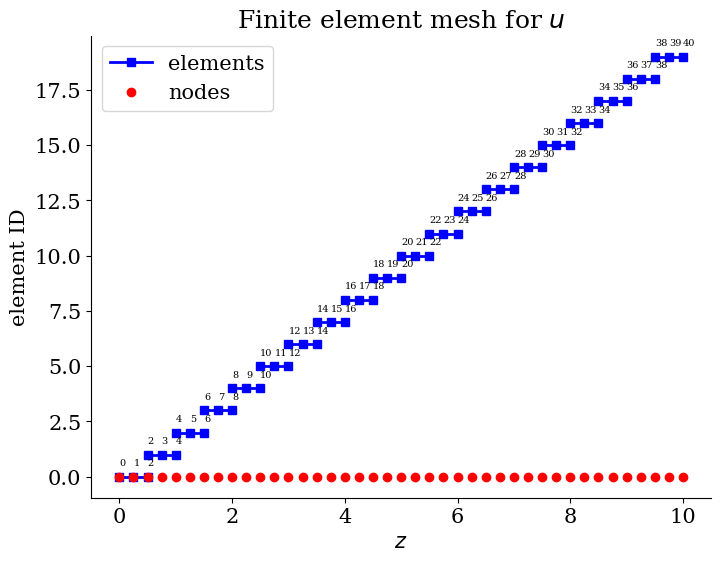

In [8]:
plt.xlabel(r'$z$')
plt.ylabel(r'element ID')
plt.title(r'Finite element mesh for $u$')
for i,elem in enumerate(elements_u):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label=r'elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
    for k in range(elem._line_element__nnodes):
        plt.text(elem._line_element__coords[k],i+0.5,str(elem._line_element__global_ids[k]),size=7)
plt.plot(nodes_u, [0]*len(nodes_u), 'ro ', label=r'nodes')
plt.legend();

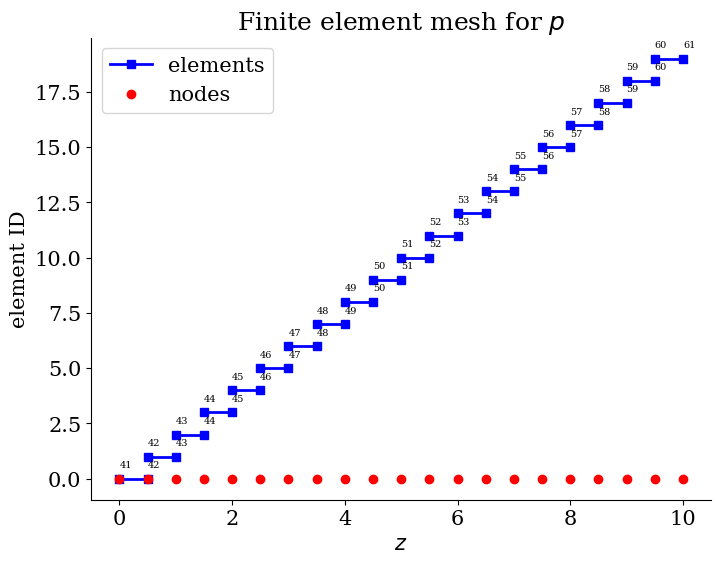

In [9]:
plt.xlabel(r'$z$')
plt.ylabel(r'element ID')
plt.title(r'Finite element mesh for $p$')
for i,elem in enumerate(elements_p):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label=r'elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
    for k in range(elem._line_element__nnodes):
        plt.text(elem._line_element__coords[k],i+0.5,str(elem._line_element__global_ids[k]),size=7)
plt.plot(nodes_p, [0]*len(nodes_p), 'ro ', label=r'nodes')
plt.legend();

In [10]:
# --------------------------------------------------------------------------
# helper: equally spaced parent-domain nodes for a p-node 1-D Lagrange element
# --------------------------------------------------------------------------
def _nodes_for_order(p):
    if p == 1:                       # constant element → single node at ξ = 0
        return np.array([0.0])
    return np.linspace(-1.0, 1.0, p) # p nodes from −1 to 1 (inclusive)

# --------------------------------------------------------------------------
# shape functions N_i(ξ)
# --------------------------------------------------------------------------
def shape_function(element_order, xi):
    """
    Vector of shape functions N_i(ξ) for a 1-D Lagrange element of any order.
    Interface is identical to the code you posted: (element_order, xi) → array.
    """
    xi    = np.asarray(xi)                             # scalar or array
    nodes = _nodes_for_order(element_order)
    p     = element_order

    N = np.ones((p,) + xi.shape, dtype=float)
    for i in range(p):
        for j in range(p):
            if j != i:
                N[i] *= (xi - nodes[j]) / (nodes[i] - nodes[j])

    # keep return shape consistent with your originals: 1-D for scalar ξ
    return N if xi.ndim else N[:, ...]

# --------------------------------------------------------------------------
# first derivatives dN_i/dξ
# --------------------------------------------------------------------------
def dshape_function_dxi(element_order, xi):
    """
    Vector of first derivatives dN_i/dξ for a 1-D Lagrange element of any order.
    Same interface as before.
    """
    xi    = np.asarray(xi)
    nodes = _nodes_for_order(element_order)
    p     = element_order

    dN = np.zeros((p,) + xi.shape, dtype=float)

    for i in range(p):
        for k in range(p):
            if k == i:
                continue
            term = 1.0 / (nodes[i] - nodes[k])
            prod = np.ones_like(xi)
            for j in range(p):
                if j != i and j != k:
                    prod *= (xi - nodes[j]) / (nodes[i] - nodes[j])
            dN[i] += term * prod

    return dN if xi.ndim else dN[:, ...]


#dz_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dz
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac

## Discretization of virtual work (weak form)

The discretized system is given as

\begin{align}
    {\sigma}_{zz}(z=H)\delta_{in_\text{n}} - {\sigma}_{zz}(z=0) \delta_{i0} + \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \gamma_\text{r} N^u_i \det J \, \text{d}\xi &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^u (\sigma_{zz}' - p)\det J  \, \text{d}\xi
    \\
    {q}_{z}(z=H)\delta_{in_\text{n}} - {q}_{z}(z=0) \delta_{i0} &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^p q_z \det J  \, \text{d}\xi - \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} N_i^p \left[ \frac{\partial_z u_z - \partial_z u_z^\text{prev}}{\Delta t} + n\beta_p\frac{p - p^\text{prev}}{\Delta t} \right]\det J  \, \text{d}\xi 
\end{align}

The latter equation was modified to yield a symmetric stiffness matrix:

\begin{align}
    {\sigma}_{zz}(z=H)\delta_{in_\text{n}} - {\sigma}_{zz}(z=0) \delta_{i0} + \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \gamma_\text{r} N^u_i \det J \, \text{d}\xi &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^u (\sigma_{zz}' - p)\det J  \, \text{d}\xi
    \\
    {q}_{z}(z=H)\delta_{in_\text{n}} \Delta t - {q}_{z}(z=0) \delta_{i0} \Delta t &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^p q_z \Delta t\det J  \, \text{d}\xi - \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} N_i^p \left[ \Delta \partial_z u_z + n\beta_p\Delta p  \right]\det J  \, \text{d}\xi 
\end{align}

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side. Local integration is performed by Gauss quadrature:

$$
    \int \limits_{-1}^1 f(\xi)\,\text{d}\xi \approx \sum \limits_{i=1}^{n_\text{gp}} f(\xi_i) w_i 
$$

## Local assember

In [11]:
def Stiffness(z):
    return 5e6

def gamma_r(z):
    return 0

def gamma_w():
    return 0

def Conductivity(z):
    return 1e-5 / 1e4 # k/mu = k_f/gamma_w

def Compressibility(z):
    return 5e-10*0.4*0

In [12]:
def local_assembler_res(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt):
    order_u = elem_u._line_element__nnodes
    order_p = elem_p._line_element__nnodes
    res_loc = np.zeros(order_u + order_p)
    z_nodes = elem_u._line_element__coords
    for i in range(elem_u._line_element__quad_degree):
        #local integration point coordinate
        xi = elem_u._line_element__quad_points[i]
        #shape function
        N_u = shape_function(order_u,xi)
        N_p = shape_function(order_p,xi)
        #gradient of shape function
        dN_u_dX = grad_shape_function(elem_u,xi)
        dN_p_dX = grad_shape_function(elem_p,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem_u,xi))
        #integration weight
        w = elem_u._line_element__quad_weights[i]        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N_u,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(-np.dot(dN_u_dX,sol_u))
        k_over_mu = Conductivity(-np.dot(dN_u_dX,sol_u))
        beta = Compressibility(z_glob)
        #evaluation of local body force contributions
        gr = gamma_r(z_glob)
        gw = gamma_w()
        
        #flux quantities
        
        q_z = - k_over_mu * (np.dot(dN_p_dX,sol_p) - gw)
        #print(q_z)
        s_z = E * np.dot(dN_u_dX,sol_u) - np.dot(N_p,sol_p)
        delta_e_vol = np.dot(dN_u_dX,(sol_u - sol_u_prev))
        delta_p = np.dot(N_p,(sol_p-sol_p_prev))
           
        res_u = dN_u_dX*s_z - N_u*gr
        res_p = dN_p_dX*q_z*dt - N_p * (delta_e_vol + beta * delta_p)
        
        #assembly of local RHS
        res_loc += np.block([res_u, res_p]) * w * detJ
    return res_loc

In [13]:
def local_assembler_res_Jac(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt,fac=1):
    order_u = elem_u._line_element__nnodes
    order_p = elem_p._line_element__nnodes
    res_loc = np.zeros(order_u + order_p)
    K_loc = np.zeros((order_u + order_p,order_u + order_p))
    z_nodes = elem_u._line_element__coords
    for i in range(elem_u._line_element__quad_degree):
        #local integration point coordinate
        xi = elem_u._line_element__quad_points[i]
        #shape function
        N_u = shape_function(order_u,xi)
        N_p = shape_function(order_p,xi)
        #gradient of shape function
        dN_u_dX = grad_shape_function(elem_u,xi)
        dN_p_dX = grad_shape_function(elem_p,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem_u,xi))
        #integration weight
        w = elem_u._line_element__quad_weights[i]        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N_u,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(-np.dot(dN_u_dX,sol_u))
        k_over_mu = Conductivity(-np.dot(dN_u_dX,sol_u))
        beta = Compressibility(0)
        #evaluation of local body force contributions
        gr = gamma_r(0)
        gw = gamma_w()
        
        #flux quantities
        
        q_z = - k_over_mu * (np.dot(dN_p_dX,sol_p) - gw)
        #print(np.dot(dN_p_dX,sol_p), gw, gr, q_z)
        s_z = E * np.dot(dN_u_dX,sol_u) - np.dot(N_p,sol_p)
        delta_e_vol = np.dot(dN_u_dX,(sol_u - sol_u_prev))
        delta_p = np.dot(N_p,(sol_p-sol_p_prev))
               
        res_u = dN_u_dX*s_z - N_u*gr
        res_p = dN_p_dX*q_z*dt - N_p * (delta_e_vol + beta * delta_p)
        
        #assembly of local Jac
        K_loc += np.block([[np.outer(dN_u_dX,dN_u_dX)*E, -np.outer(dN_u_dX,N_p)],
                           [-np.outer(N_p,dN_u_dX), -np.outer(dN_p_dX,dN_p_dX)*k_over_mu*dt - np.outer(N_p,N_p)*beta]]) * w * detJ
        
        #assembly of local RHS
        res_loc += np.block([res_u, res_p]) * w * detJ
    return K_loc, res_loc

In [14]:
def local_assembler_Picard(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt,fac=1):
    order_u = elem_u._line_element__nnodes
    order_p = elem_p._line_element__nnodes
    rhs_loc = np.zeros(order_u + order_p)
    K_loc = np.zeros((order_u + order_p,order_u + order_p))
    M_loc = np.zeros((order_u + order_p,order_u + order_p))
    z_nodes = elem_u._line_element__coords
    for i in range(elem_u._line_element__quad_degree):
        #local integration point coordinate
        xi = elem_u._line_element__quad_points[i]
        #shape function
        N_u = shape_function(order_u,xi)
        N_p = shape_function(order_p,xi)
        #gradient of shape function
        dN_u_dX = grad_shape_function(elem_u,xi)
        dN_p_dX = grad_shape_function(elem_p,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem_u,xi))
        #integration weight
        w = elem_u._line_element__quad_weights[i]        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N_u,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(0)
        k_over_mu = Conductivity(0)
        beta = Compressibility(0)
        #evaluation of local body force contributions
        gr = gamma_r(0)
        gw = gamma_w()
        
        #flux quantities
        
        q_z = - k_over_mu * (np.dot(dN_p_dX,sol_p) - gw)
        s_z = E * np.dot(dN_u_dX,sol_u) - np.dot(N_p,sol_p)
        delta_e_vol = np.dot(dN_u_dX,(sol_u - sol_u_prev))
        delta_p = np.dot(N_p,(sol_p-sol_p_prev))
               
        rhs_u = N_u*gr
        rhs_p = dN_p_dX*k_over_mu*gw
        
        #assembly of local Jac
        K_loc += np.block([[np.outer(dN_u_dX,dN_u_dX)*E, -np.outer(dN_u_dX,N_p)],
                           [np.outer(N_p,dN_u_dX)*0, np.outer(dN_p_dX,dN_p_dX)*k_over_mu]]) * w * detJ
        M_loc += np.block([[np.outer(dN_u_dX,dN_u_dX)*0, -np.outer(dN_u_dX,N_p)*0],
                           [np.outer(N_p,dN_u_dX), np.outer(N_p,N_p)*beta]]) * w * detJ
        
        #assembly of local RHS
        rhs_loc += np.block([rhs_u, rhs_p]) * w * detJ
    return K_loc + M_loc/dt, rhs_loc + M_loc@np.append(sol_u_prev,sol_p_prev)/dt

In [15]:
epsilon = lambda p: np.maximum(1e-8,1e-8*p)

# could use forward differences to safe one set of evaluations
def local_assembler_Jac(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt):
    #print("res")
    order_u = elem_u._line_element__nnodes
    order_p = elem_p._line_element__nnodes
    Jac = np.zeros((order_u+order_p,order_u+order_p))
    r0 = local_assembler_res(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt)
    sol = np.append(sol_u,sol_p)
    sol_prev = np.append(sol_u_prev,sol_p_prev)
    for j in range(len(sol_u)):
        #print("Jac ", j)
        upper_up = np.copy(sol)
        eps = np.maximum(1e-8,1e-8*sol[j])
        upper_up[j] += eps
        Jac[:,j] = (local_assembler_res(elem_u,elem_p,upper_up[0:len(sol_u)],
                                        upper_up[len(sol_u):],sol_u_prev,sol_p_prev,dt)
                    - r0)/eps
        for j in range(len(sol_u),len(sol)):
            #print("Jac ", j)
            upper_up = np.copy(sol)
            eps = np.maximum(1e-1,1e-8*sol[j])
            upper_up[j] += eps
            Jac[:,j] = (local_assembler_res(elem_u,elem_p,upper_up[0:len(sol_u)],
                                            upper_up[len(sol_u):],sol_u_prev,sol_p_prev,dt)
                        - r0)/eps
    return Jac, r0

In [16]:
def epsilon(p):
    return np.maximum(1e-8, 1e-8 * p)

def local_assembler_Jac2(elem_u, elem_p, sol_u, sol_p, sol_u_prev, sol_p_prev, dt):
    order_u = elem_u._line_element__nnodes
    order_p = elem_p._line_element__nnodes
    Jac = np.zeros((order_u + order_p, order_u + order_p))

    sol = np.append(sol_u, sol_p)
    sol_prev = np.append(sol_u_prev, sol_p_prev)

    r0 = local_assembler_res(elem_u, elem_p, sol_u, sol_p, sol_u_prev, sol_p_prev, dt)

    split_idx = len(sol_u)
    eps = np.where(
        np.arange(len(sol)) < split_idx,
        np.maximum(1e-8, 1e-8 * sol),   # For u part
        np.maximum(1e-1, 1e-8 * sol)    # For p part
    )

    for j in range(len(sol)):
        perturbed_sol = sol.copy()
        perturbed_sol[j] += eps[j]

        res_perturbed = local_assembler_res(
            elem_u, elem_p,
            perturbed_sol[:split_idx],   # sol_u
            perturbed_sol[split_idx:],   # sol_p
            sol_u_prev, sol_p_prev, dt
        )
        Jac[:, j] = (res_perturbed - r0) / eps[j]

    return Jac, r0


In [17]:
elem_u = elements_u[1]
elem_p = elements_p[1]

IDs_u = elem_u._line_element__global_ids
IDs_p = elem_p._line_element__global_ids
        #
el_sol_u = np.array([solution[IDs_u[i]] for i in range(len(IDs_u))])
el_sol_p = np.array([solution[IDs_p[i]] for i in range(len(IDs_p))])

In [18]:
local_assembler_res(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,10)

array([0., 0., 0., 0., 0.])

In [19]:
K,r = local_assembler_Picard(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,10)
np.linalg.cond(K)

np.float64(5.7098959814013304e+16)

In [20]:
K,r = local_assembler_Jac(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,10)
print(K)
print(r)

[[ 2.33333333e+07 -2.66666667e+07  3.33333333e+06  8.33333333e-01
   1.66666667e-01]
 [-2.66666667e+07  5.33333333e+07 -2.66666667e+07 -6.66666667e-01
   6.66666667e-01]
 [ 3.33333333e+06 -2.66666667e+07  2.33333333e+07 -1.66666667e-01
  -8.33333333e-01]
 [ 8.33333333e-01 -6.66666667e-01 -1.66666667e-01 -2.00000000e-08
   2.00000000e-08]
 [ 1.66666667e-01  6.66666667e-01 -8.33333333e-01  2.00000000e-08
  -2.00000000e-08]]
[0. 0. 0. 0. 0.]


In [21]:
K2,r2 = local_assembler_res_Jac(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,10)
print(K2)
print(r)
np.linalg.cond(K2)

[[ 2.33333333e+07 -2.66666667e+07  3.33333333e+06  8.33333333e-01
   1.66666667e-01]
 [-2.66666667e+07  5.33333333e+07 -2.66666667e+07 -6.66666667e-01
   6.66666667e-01]
 [ 3.33333333e+06 -2.66666667e+07  2.33333333e+07 -1.66666667e-01
  -8.33333333e-01]
 [ 8.33333333e-01 -6.66666667e-01 -1.66666667e-01 -2.00000000e-08
   2.00000000e-08]
 [ 1.66666667e-01  6.66666667e-01 -8.33333333e-01  2.00000000e-08
  -2.00000000e-08]]
[0. 0. 0. 0. 0.]


np.float64(5.709895981401257e+16)

In [22]:
print((K2-K)/K)

[[-1.59655299e-16 -0.00000000e+00  2.79396772e-16 -2.66453526e-16
   0.00000000e+00]
 [ 1.39698386e-16  1.39698386e-16  1.39698386e-16  3.33066907e-16
   3.33066907e-16]
 [ 2.79396772e-16 -0.00000000e+00 -1.59655299e-16 -0.00000000e+00
  -0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.65436123e-16
  -1.65436123e-16]
 [ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 -1.65436123e-16
  -1.65436123e-16]]


Text(0, 0.5, 'condition number of Jacobian')

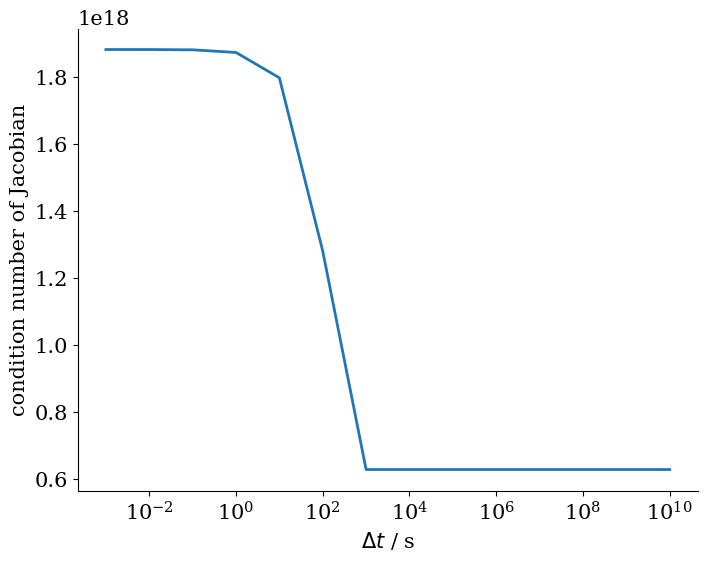

In [23]:
def Stiffness(z):
    return 1e8

def gamma_r(z):
    return -2e4

def gamma_w():
    return -1e4

def Conductivity(z):
    return 1e-12 # k/mu = k_f/gamma_w

def Compressibility(z):
    return 5e-10*0.4

dts = np.logspace(-3,10,14)
conds = dts*0
for i,dt in enumerate(dts):
    K,r = local_assembler_res_Jac(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,dt)
    conds[i] = np.linalg.cond(K)
plt.plot(dts,conds)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\Delta t$ / s')
plt.ylabel(r'condition number of Jacobian')

In [24]:
print(K2-K2.T)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


Symmetric, but ill-conditioned, analytical Jacobian confirmed numerically (and more stable).

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [25]:
def global_assembler(elements_u,elements_p,solution,solution_prev,dt,f=local_assembler_res_Jac):
    K_glob = np.zeros((len(solution),len(solution)))
    b_glob = np.zeros(len(solution))
    for i,elem in enumerate(elements_u):
        #DOF table
        IDs_u = elem._line_element__global_ids
        IDs_p = elements_p[i]._line_element__global_ids
        #
        el_sol_u = np.array([solution[IDs_u[i]] for i in range(len(IDs_u))])
        el_sol_p = np.array([solution[IDs_p[i]] for i in range(len(IDs_p))])
        el_sol_u_prev = np.array([solution_prev[IDs_u[i]] for i in range(len(IDs_u))])
        el_sol_p_prev = np.array([solution_prev[IDs_p[i]] for i in range(len(IDs_p))])
        K_i, b_i = f(elem,elements_p[i],el_sol_u,el_sol_p,el_sol_u_prev,el_sol_p_prev,dt)
        for j in range(len(IDs_u)):
            b_glob[IDs_u[j]] += b_i[j]
            for k in range(len(IDs_u)):
                K_glob[IDs_u[j],IDs_u[k]] += K_i[j,k]
            for k in range(len(IDs_p)):
                K_glob[IDs_u[j],IDs_p[k]] += K_i[j,k+len(IDs_u)]
        for j in range(len(IDs_p)):
            b_glob[IDs_p[j]] += b_i[j+len(IDs_u)]
            for k in range(len(IDs_u)):
                K_glob[IDs_p[j],IDs_u[k]] += K_i[j+len(IDs_u),k]
            for k in range(len(IDs_p)):
                K_glob[IDs_p[j],IDs_p[k]] += K_i[j+len(IDs_u),k+len(IDs_u)]
            
    return K_glob, b_glob

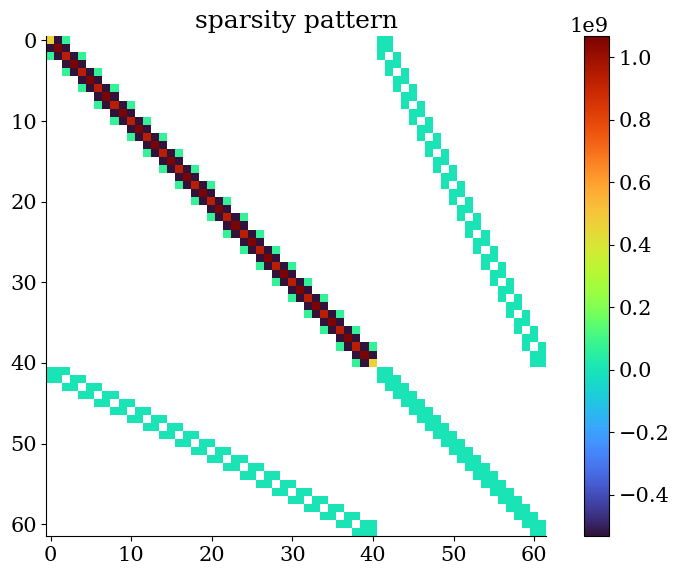

In [26]:
K, f = global_assembler(elements_u,elements_p,solution,solution*1.1,0.5,f=local_assembler_res_Jac)
plt.imshow(K, cmap='turbo',alpha=np.where(K==0,0.,1.))
plt.colorbar()
plt.title(r'sparsity pattern')
plt.tight_layout()

## Application of boundary conditions

Now we apply the natural (Neumann, nodal force) and the essential (Dirichlet, nodal displacement) boundary conditions.

In [27]:
def apply_Neumann_bc(b_glob,node_id,value):
    b_glob[node_id] += value
    return b_glob

A Dirichlet boundary condition is introduced via

$b_0 \leftarrow K_{0,0}(u_0 - \bar{u})$ so that $\Delta u_0 = \bar{u} - u_0$ and matrix condition number is not changed.

$b_{i \neq 0} \leftarrow b_{i\neq 0} - K_{i,0} (u_0 - \bar{u})$

$K_{0,i\neq 0} = K_{i\neq 0,0} \leftarrow 0$ 

This preserves $K_{ij} = K_{ji}$

In [28]:
#adapted to incremental scheme
def apply_Dirichlet_bc(K_glob,b_glob,solution,node_id,value):
    c = K_glob[node_id,node_id]
    if c == 0:
        c = 1
    target = solution[node_id] - value
    
    #for i in range(len(b_glob)):
    b_glob[:] -= K_glob[:,node_id] * target
    b_glob[node_id] = c*target #no increment
    K_glob[node_id,:] = 0.
    K_glob[:,node_id] = 0.
    
    K_glob[node_id,node_id] = c

    #solution[node_id] = value
    return K_glob, b_glob

In [29]:
def converged(inc_u,inc_p):
    n_u = np.linalg.norm(inc_u,np.inf)#np.linalg.norm(inc_u)/len(inc_u)
    n_p = np.linalg.norm(inc_p,np.inf)#np.linalg.norm(inc_p)/len(inc_p)
    #print(n_u, n_p)
    if (n_u <= 1e-12 and n_p <= 1e-6):
        return True
    else:
        return False

In [30]:
def time_loop(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 50
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u),elements_u[0]._line_element__nnodes,elements_p[0]._line_element__nnodes) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u),elements_u[0]._line_element__nnodes,elements_p[0]._line_element__nnodes) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
        #inc = sp.linalg.solve(K,-f)
        sK = sp.sparse.csr_matrix(K) 
        inc = spsolve(sK,-f)
        #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
        #lu, piv = sp.linalg.lu_factor(K)
        #inc = sp.linalg.lu_solve((lu, piv), -f)
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
            #print(err)
            #inc = sp.linalg.solve(K,-f)
            sK = sp.sparse.csr_matrix(K) 
            inc = spsolve(sK,-f)
            #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
            #lu, piv = sp.linalg.lu_factor(K)
            #inc = sp.linalg.lu_solve((lu, piv), -f)
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

## Consolidation under self weight

In [31]:
number_of_elements = 20
L = 10.
nodes_per_element_u = 3
nodes_per_element_p = 2

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element_u,nodes_per_element_p,'u')
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element_u,nodes_per_element_p,'p')
solution = np.append(solution_u,solution_p)

In [32]:
def Stiffness(z):
    return 1e8

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    return 1e-14/1e-3

def Compressibility(z):
    return 5e-10*0.4

In [33]:
day_in_sec = 86400

In [34]:
p_top = lambda t: 1e5
times, sols = time_loop(elements_u,elements_p,solution,day_in_sec,day_in_sec*10,p_top)

Solving time step 1.
Performed 1 iterations.
Solving time step 2.
Performed 1 iterations.
Solving time step 3.
Performed 1 iterations.
Solving time step 4.
Performed 1 iterations.
Solving time step 5.
Performed 1 iterations.
Solving time step 6.
Performed 1 iterations.
Solving time step 7.
Performed 1 iterations.
Solving time step 8.
Performed 1 iterations.
Solving time step 9.
Performed 1 iterations.
Solving time step 10.
Performed 1 iterations.


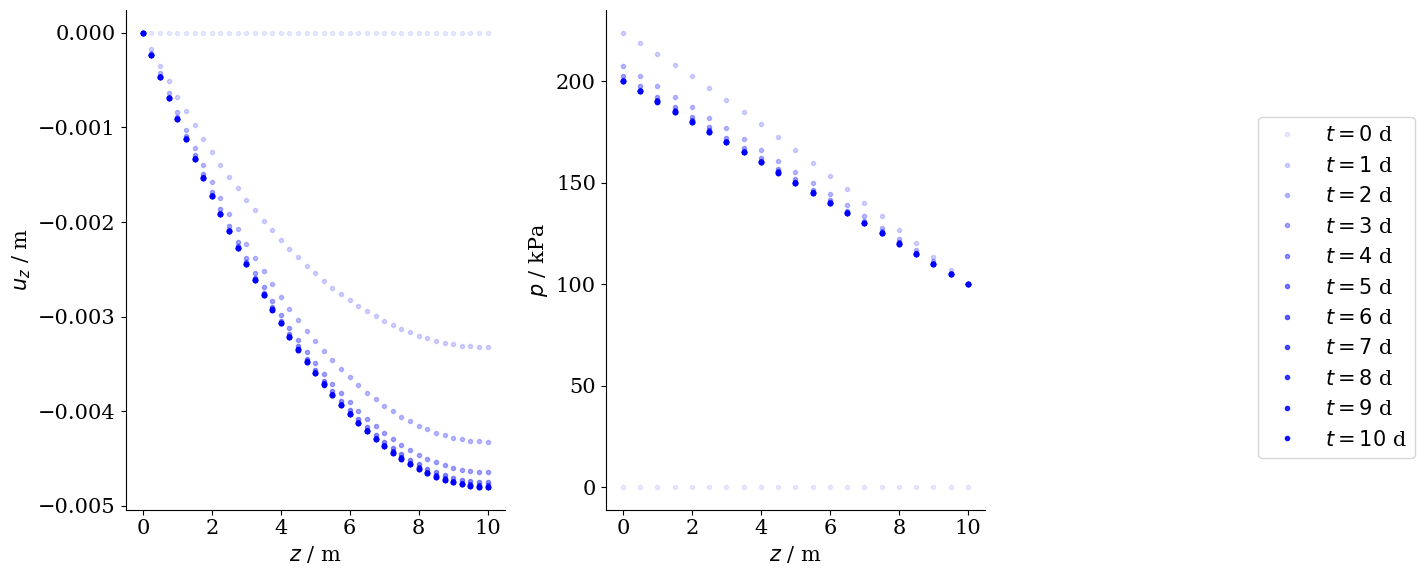

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
for i, t in enumerate(times):
    sol_u, sol_p = split_sol(len(elements_u), sols[i],nodes_per_element_u,nodes_per_element_p)
    ax[0].plot(nodes_u, sol_u, label=r'$t = %i$ d' % (t/day_in_sec), color='blue', alpha=(i+1)/(len(times)+1), ls='', marker='.')
    ax[1].plot(nodes_p, sol_p/1e3, color='blue', alpha=(i+1)/(len(times)+1), ls='', marker='.')

ax[0].set_xlabel(r'$z$ / m')
ax[1].set_xlabel(r'$z$ / m')
ax[0].set_ylabel(r'$u_z$ / m')
ax[1].set_ylabel(r'$p$ / kPa')
# Add the legend next to the plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend

Condition number bad for:
- small $\Delta t$
- low $E$ (but high $E$ makes problem more stable)
- low $k$
- low $\beta$

## Testing restart / IC

Starting the same simulation but with final result.

In [36]:
times, sols = time_loop(elements_u,elements_p,sols[-1],day_in_sec,4*day_in_sec,p_top)

Solving time step 1.
Performed 1 iterations.
Solving time step 2.
Performed 1 iterations.
Solving time step 3.
Performed 1 iterations.
Solving time step 4.
Performed 1 iterations.


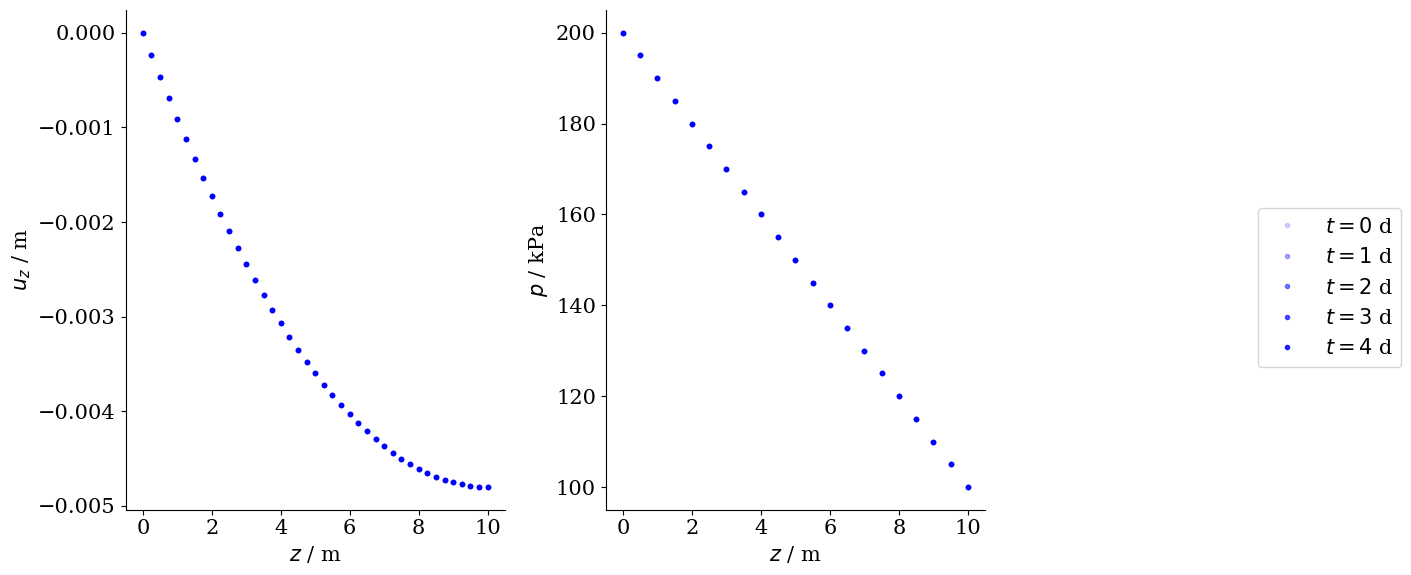

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
for i, t in enumerate(times):
    sol_u, sol_p = split_sol(len(elements_u), sols[i],nodes_per_element_u,nodes_per_element_p)
    ax[0].plot(nodes_u, sol_u, label=r'$t = %i$ d' % (t/day_in_sec), color='blue', alpha=(i+1)/(len(times)+1), ls='', marker='.')
    ax[1].plot(nodes_p, sol_p/1e3, color='blue', alpha=(i+1)/(len(times)+1), ls='', marker='.')

ax[0].set_xlabel(r'$z$ / m')
ax[1].set_xlabel(r'$z$ / m')
ax[0].set_ylabel(r'$u_z$ / m')
ax[1].set_ylabel(r'$p$ / kPa')
# Add the legend next to the plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend

## Consolidation

As in Terzaghi scripts.

In [38]:
number_of_elements = 20
L = 10
nodes_per_element_u = 4
nodes_per_element_p = 3

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element_u,nodes_per_element_p,'u')
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element_u,nodes_per_element_p,'p')
solution = np.append(solution_u,solution_p)

In [39]:
def Stiffness(z):
    return 5e6

def gamma_r(z):
    return 0

def gamma_w():
    return 0

def Conductivity(z):
    return 1e-5 / 1e4 # k/mu = k_f/gamma_w

def Compressibility(z):
    return 5e-10*0.4

In [40]:
def time_loop(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 20
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u),elements_u[0]._line_element__nnodes,elements_p[0]._line_element__nnodes) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u),elements_u[0]._line_element__nnodes,elements_p[0]._line_element__nnodes) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        #f = apply_Neumann_bc(f,n_ids_p[0],1e-14*dt) #apply top load
        #K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[-1], -1e-2)
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        #for k in range(len(n_ids_u)):
        #    K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[k], nodes_u[k]/100) #Fix p at top
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], 0.) #Fix p at top
        #inc = sp.linalg.solve(K,-f)
        sK = sp.sparse.csr_matrix(K) 
        inc = spsolve(sK,-f)
        #inc = sp.sparse.linalg.bicg(K, -f)[0]
        #lu, piv = sp.linalg.lu_factor(K)
        #inc = sp.linalg.lu_solve((lu, piv), -f)
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            #f = apply_Neumann_bc(f,n_ids_p[0],1e-14*dt) #apply top load
            #K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[-1], -1e-2)
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            #for k in range(len(n_ids_u)):
            #    K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[k], nodes_u[k]/100) #Fix p at top
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], 0.) #Fix p at top
            #print(err)
            #inc = sp.linalg.solve(K,-f)
            sK = sp.sparse.csr_matrix(K) 
            inc = spsolve(sK,-f)
            #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
            #lu, piv = sp.linalg.lu_factor(K)
            #inc = sp.linalg.lu_solve((lu, piv), -f)
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

In [41]:
day_in_sec = 86400
p_top = lambda t: 2e5
times, sols = time_loop(elements_u,elements_p,solution,10,10,p_top)
dts = np.logspace(1,5,10)
for dt in dts:
    times_i, sols_i = time_loop(elements_u,elements_p,sols[-1],dt,dt,p_top)
    times = np.append(times,times_i+times[-1],0)
    sols = np.append(sols,sols_i,0)

Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.
Solving time step 1.
Performed 1 iterations.


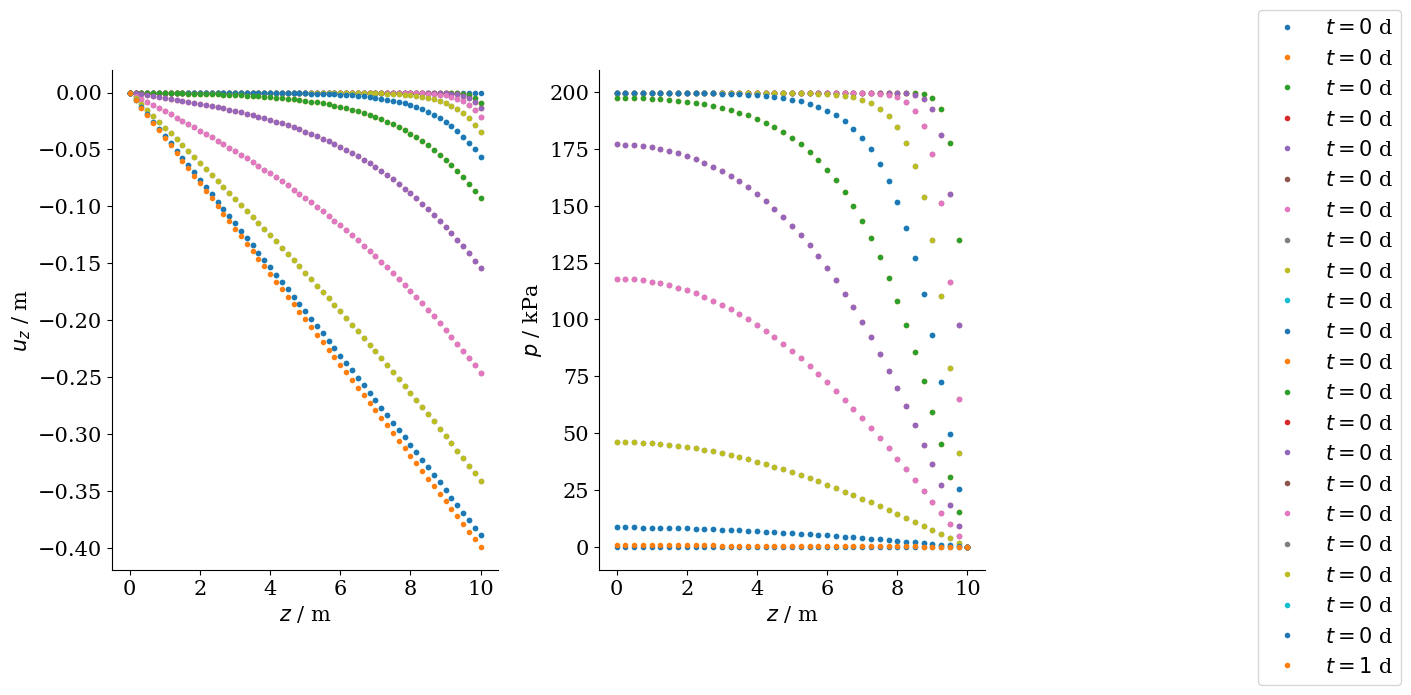

In [42]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ttimes = [0,1,2,3,-1]
for i,t in enumerate(times):
    #t = times[i]
    sol_u, sol_p = split_sol(len(elements_u), sols[i],nodes_per_element_u,nodes_per_element_p)
    ax[0].plot(nodes_u, sol_u, label=r'$t = %i$ d' % (t/day_in_sec), ls='', marker='.')#,alpha=(t/times[-1]),color='blue')
    ax[1].plot(nodes_p, sol_p/1e3, ls='', marker='.')#,alpha=(t/times[-1]),color='blue')

ax[0].set_xlabel(r'$z$ / m')
ax[1].set_xlabel(r'$z$ / m')
ax[0].set_ylabel(r'$u_z$ / m')
ax[1].set_ylabel(r'$p$ / kPa')
# Add the legend next to the plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend

## Pressure drawdown

In [43]:
number_of_elements = 10
L = 10.
nodes_per_element_u = 4
nodes_per_element_p = 3

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element_u,nodes_per_element_p,'u')
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element_u,nodes_per_element_p,'p')
solution = np.append(solution_u,solution_p)

In [44]:
def time_loop(elements_u,elements_p,solution,dt,t_end,p_top,debug=False,damping=1.):
    #Startwerte
    max_iter = 30
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u),elements_u[0]._line_element__nnodes,elements_p[0]._line_element__nnodes) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u),elements_u[0]._line_element__nnodes,elements_p[0]._line_element__nnodes) for item in sublist])
    #
    #dampings = np.append(np.array([0.1,0.2,0.4,0.8]),np.ones(max_iter))
    dampings = np.ones(max_iter)
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)#,f=local_assembler_Jac2)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
        #Dinv = np.diag(1/np.diag(K))
        #inc = sp.linalg.solve(Dinv@K,-Dinv@f)
        sK = sp.sparse.csr_matrix(K) 
        inc = spsolve(sK,-f)
        #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
        #print("Increment ", inc)
        damping = dampings[0]
        y_old += damping*inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)#,f=local_assembler_Jac2)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
            #print(err)
            #inc = sp.linalg.solve(K,-f)
            sK = sp.sparse.csr_matrix(K) 
            inc = spsolve(sK,-f)
            #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
            #print("Increment ", inc)
            y_old += np.minimum(dampings[i],1)*inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

In [45]:
def Stiffness(z):
    return 1e8 * np.heaviside(z,0) + 1e1*np.heaviside(-z,0)
    return 1e8

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    #return 1e-17/1e-3 * np.heaviside(z,0) + 1e-12/1e-3*np.heaviside(-z,0)
    return 1e-12/1e-3

def Compressibility(z):
    return 5e-10*0.4

In [46]:
day_in_sec = 86400
p_top = lambda t: 1e5
times, sols = time_loop(elements_u,elements_p,solution,day_in_sec,10*day_in_sec,p_top,damping=1)

Solving time step 1.
Performed 20 iterations.
Solving time step 2.
Performed 1 iterations.
Solving time step 3.
Performed 1 iterations.
Solving time step 4.
Performed 1 iterations.
Solving time step 5.
Performed 1 iterations.
Solving time step 6.
Performed 0 iterations.
Solving time step 7.
Performed 0 iterations.
Solving time step 8.
Performed 0 iterations.
Solving time step 9.
Performed 0 iterations.
Solving time step 10.
Performed 0 iterations.


In [47]:
from sympy import latex
from IPython.display import Math

sigma_s, eps_s, u_s, gamma_r_s, gamma_w_s, z_s, E_s = symp.symbols('sigma epsilon u gamma_r gamma_w z E')
sigma_s = (10-z_s)*(gamma_r_s - gamma_w_s)
eps_s = sigma_s/E_s
u_s = symp.integrate(eps_s, z_s) + symp.Symbol('C')
C = symp.solve(u_s.subs(z_s, 0), 'C')[0]
u_s = u_s.subs('C', C)
u_func = symp.lambdify((z_s, gamma_r_s, gamma_w_s, E_s), u_s, 'numpy')
u_s

z**2*(-gamma_r + gamma_w)/(2*E) + z*(10*gamma_r - 10*gamma_w)/E

In [48]:
def initial_state(z_u,z_p):
    p0 = 1e5-(gamma_w())*(10-z_p)
    u0 = u_func(z_u,gamma_r(z_u),gamma_w(),Stiffness(1e-3))
    return u0, p0

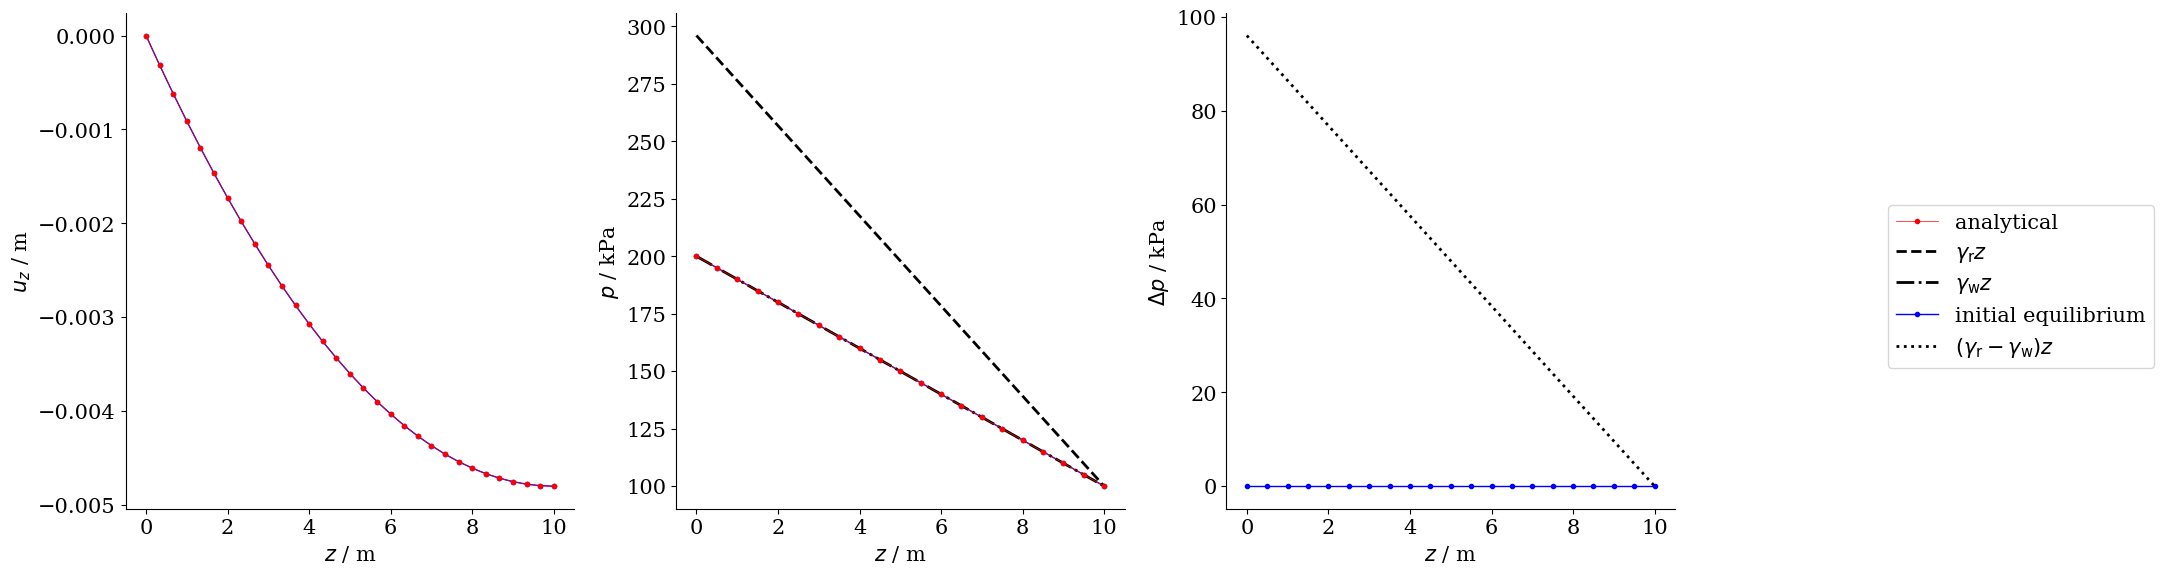

In [49]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
sol_u, sol_p = split_sol(len(elements_u), sols[-1],nodes_per_element_u,nodes_per_element_p)

ax[0].plot(nodes_u, sol_u, color='blue', marker='.',lw=1)
ax[1].plot(nodes_p, sol_p/1e3, color='blue', marker='.',lw=1)
ax[2].plot(nodes_p, sol_p/1e3- (p_top(t)/1e3 - gamma_w()/1e3*(10-nodes_p)), color='blue', marker='.',lw=1, label=r'initial equilibrium')

ax[1].plot(nodes_p, p_top(t)/1e3-(gamma_r(0))/1e3*(10-nodes_p),color='black',ls='--',label=r'$\gamma_\mathrm{r} z$')
ax[1].plot(nodes_p, p_top(t)/1e3-(gamma_w())/1e3*(10-nodes_p),color='black',ls='-.',label=r'$\gamma_\mathrm{w} z$')
ax[2].plot(nodes_p, -(gamma_r(0)-gamma_w())/1e3*(10-nodes_p),color='black',ls=':',label=r'$(\gamma_\mathrm{r}-\gamma_\mathrm{w}) z$')

u_0, p_0 = initial_state(nodes_u,nodes_p)
ax[0].plot(nodes_u, u_0, color='red', marker='.',lw=0.5, label='analytical')
ax[1].plot(nodes_p, p_0/1e3, color='red', marker='.',lw=0.5)

ax[0].set_xlabel(r'$z$ / m')
ax[1].set_xlabel(r'$z$ / m')
ax[2].set_xlabel(r'$z$ / m')
ax[0].set_ylabel(r'$u_z$ / m')
ax[1].set_ylabel(r'$p$ / kPa')
ax[2].set_ylabel(r'$\Delta p$ / kPa')
#ax[2].set_ylim(0,50)
# Add the legend next to the plots
handles, labels = [], []
for axis in ax:
    h, l = axis.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the layout to make room for the legend

In [69]:
drawdown = 1e5
duration = 20
p_drawdown = lambda t: 1e5 - drawdown/duration*np.minimum(t,duration)

def Stiffness(z):
    return 1e8 * np.heaviside(z,0) + 1e2*np.heaviside(-z,0)
    #return 1e7 * expit(5e4 * (z - 0.001)) + 1e1
    nu = 1500.
    omega = 0.75
    sigma_at = 1e5
    #return np.power(z*nu*(1-omega)*np.power(sigma_at,1-omega),1/(1-omega))
    #return np.maximum(1e3,np.power(z*nu*(1-omega)*np.power(sigma_at,1-omega),1/(1-omega))) * np.heaviside(z,0) + 1e3*np.heaviside(-z,0)

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    #return 1e-17/1e-3 * np.heaviside(z,0) + 1e-12/1e-3*np.heaviside(-z,0)
    return 1e-19/1e-3

def Compressibility(z):
    return 5e-8*0.4

In [70]:
def initial_suspension_state(z_u,z_p):
    p0 = 1e5-(gamma_r(0))*(10-z_p)
    #phyd = 1e5-(gamma_w())*(10-z_p)
    #psusp = phyd[-2]-(gamma_r(0))*(z_p[-2]-z_p[0:-2])
    #p_gesamt = np.append(psusp,phyd[-2:])
    u0 = z_u*0.05
    #print(phyd, p_gesamt)
    return u0, p0

In [71]:
#times, sols_dd = time_loop(elements_u,elements_p,sols[-1],duration/5,duration*2,p_drawdown)
u_0, p_0 = initial_state(nodes_u,nodes_p)#initial_state(nodes_u,nodes_p)
times, sols_dd = time_loop(elements_u,elements_p,np.append(u_0,p_0),duration/10,duration,p_drawdown,damping=1)
#dts = np.logspace(4,6,2)
#for dt in dts:
#    times_i, sols_i = time_loop(elements_u,elements_p,sols_dd[-1],dt,dt,p_drawdown)
#    times = np.append(times,times_i+times[-1],0)
#    sols_dd = np.append(sols_dd,sols_i,0)

Solving time step 1.
Performed 3 iterations.
Solving time step 2.
Performed 2 iterations.
Solving time step 3.
Performed 3 iterations.
Solving time step 4.
Performed 4 iterations.
Solving time step 5.
Performed 3 iterations.
Solving time step 6.
Performed 3 iterations.
Solving time step 7.
Performed 3 iterations.
Solving time step 8.
Performed 3 iterations.
Solving time step 9.
Performed 3 iterations.
Solving time step 10.
Performed 2 iterations.


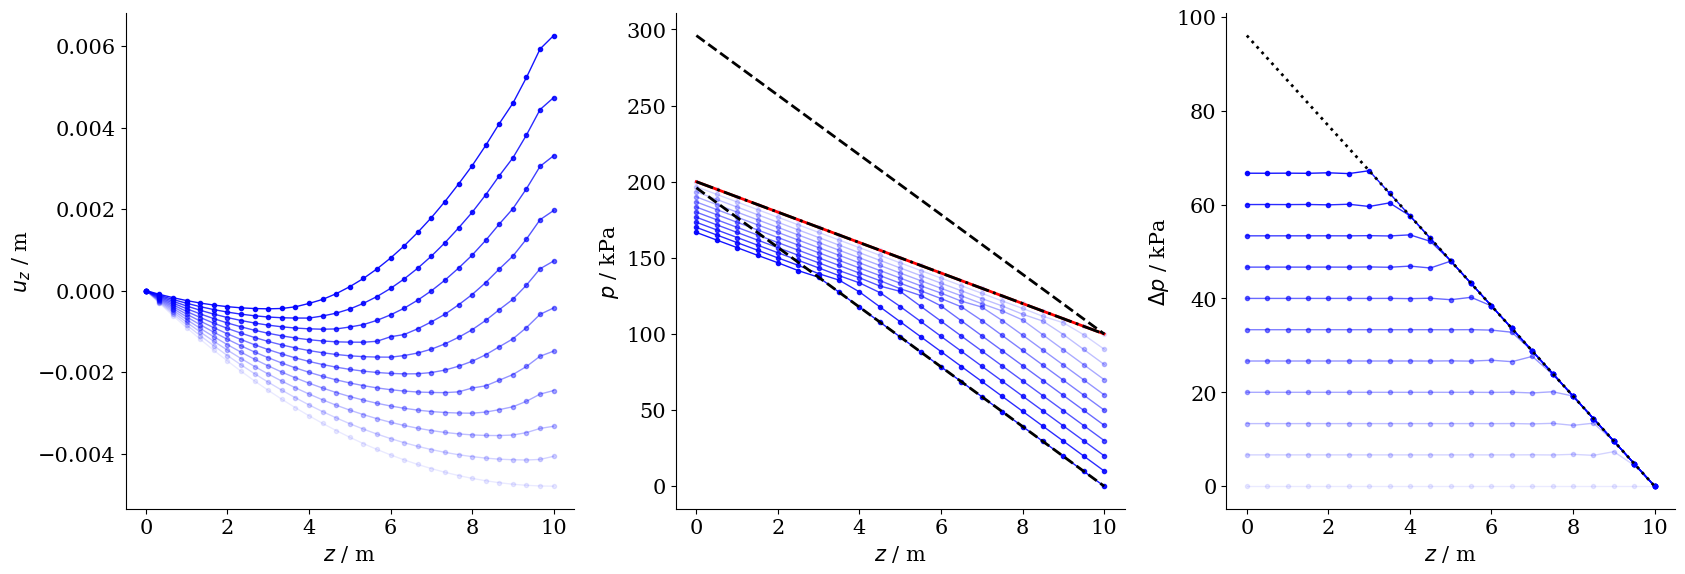

In [72]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
for i, t in enumerate(times):
    sol_u, sol_p = split_sol(len(elements_u), sols_dd[i],nodes_per_element_u,nodes_per_element_p)
    ax[0].plot(nodes_u, sol_u, color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1)
    ax[1].plot(nodes_p, sol_p/1e3, color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1)
    ax[2].plot(nodes_p, sol_p/1e3- (p_drawdown(t)/1e3 - gamma_w()/1e3*(10-nodes_p)), color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1, label=r'$t = %i$ d' % (t/day_in_sec))

ax[1].plot(nodes_p,p_0/1e3,color='red')
ax[1].plot(nodes_p, p_drawdown(t)/1e3-(gamma_r(0))/1e3*(10-nodes_p),color='black',ls='--',label=r'$\gamma_\mathrm{r} z$')
ax[1].plot(nodes_p, p_top(t)/1e3-(gamma_r(0))/1e3*(10-nodes_p),color='black',ls='--',label=r'$\gamma_\mathrm{r} z$')
ax[1].plot(nodes_p, p_top(t)/1e3-(gamma_w())/1e3*(10-nodes_p),color='black',ls='-.',label=r'$\gamma_\mathrm{w} z$')
ax[2].plot(nodes_p, -(gamma_r(0)-gamma_w())/1e3*(10-nodes_p),color='black',ls=':',label=r'$(\gamma_\mathrm{r}-\gamma_\mathrm{w}) z$')

ax[0].set_xlabel(r'$z$ / m')
ax[1].set_xlabel(r'$z$ / m')
ax[2].set_xlabel(r'$z$ / m')
ax[0].set_ylabel(r'$u_z$ / m')
ax[1].set_ylabel(r'$p$ / kPa')
ax[2].set_ylabel(r'$\Delta p$ / kPa')
#ax[2].set_ylim(0,50)
# Add the legend next to the plots
handles, labels = ax[2].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the layout to make room for the legend

## Sedimentation

In [73]:
drawdown = 1e5
duration = 60*60*2
p_drawdown = lambda t: 1e5

def Stiffness(z):
    value = 1e6 * np.heaviside(z,0) + 1e3*np.heaviside(-z,0)
    return value
    #return 1e5 * np.heaviside(z,0) + (1e7-1e5)*np.heaviside(z-1e-2,0) + 1e1*np.heaviside(-z,0)
    #return 1e7 * expit(5e4 * (z - 0.001)) + 1e1
    return 1e1+np.heaviside(z,0)*1e7*np.minimum(z/0.01,1.)
    nu = 1500.
    omega = 0.75
    sigma_at = 1e5
    #return np.power(z*nu*(1-omega)*np.power(sigma_at,1-omega),1/(1-omega))
    return np.maximum(1e3,np.power(z*nu*(1-omega)*np.power(sigma_at,1-omega),1/(1-omega))) * np.heaviside(z,0) + 1e3*np.heaviside(-z,0)

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    #return 1e-17/1e-3 * np.heaviside(z,0) + 1e-12/1e-3*np.heaviside(-z,0)
    return 1e-11/1e-3

def Compressibility(z):
    return 5e-8*0.4

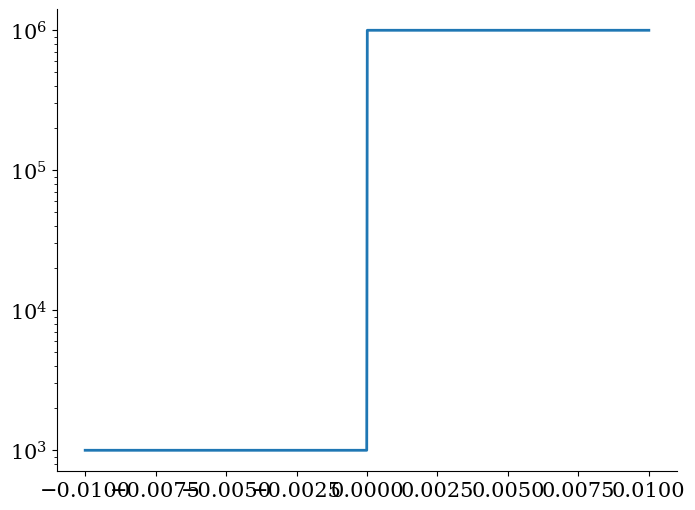

In [74]:
aa = np.linspace(-1e-2,1e-2,1000)
plt.plot(aa,Stiffness(aa))
plt.yscale('log')

In [75]:
def initial_suspension_state(z_u,z_p):
    p0 = 1e5-(gamma_r(0))*(10-z_p)
    #phyd = 1e5-(gamma_w())*(10-z_p)
    #psusp = phyd[-2]-(gamma_r(0))*(z_p[-2]-z_p[0:-2])
    #p_gesamt = np.append(psusp,phyd[-2:])
    u0 = z_u*0.05
    #print(phyd, p_gesamt)
    return u0, p0

In [76]:
#times, sols_dd = time_loop(elements_u,elements_p,sols[-1],duration/5,duration*2,p_drawdown)
u_0, p_0 = initial_suspension_state(nodes_u,nodes_p)#initial_state(nodes_u,nodes_p)
times, sols_dd = time_loop(elements_u,elements_p,np.append(u_0,p_0),duration/10,duration,p_drawdown,damping=1)
#dts = np.logspace(4,6,2)
#for dt in dts:
#    times_i, sols_i = time_loop(elements_u,elements_p,sols_dd[-1],dt,dt,p_drawdown)
#    times = np.append(times,times_i+times[-1],0)
#    sols_dd = np.append(sols_dd,sols_i,0)

Solving time step 1.
Performed 4 iterations.
Solving time step 2.
Performed 3 iterations.
Solving time step 3.
Performed 3 iterations.
Solving time step 4.
Performed 3 iterations.
Solving time step 5.
Performed 3 iterations.
Solving time step 6.
Performed 3 iterations.
Solving time step 7.
Performed 4 iterations.
Solving time step 8.
Performed 5 iterations.
Solving time step 9.
Performed 3 iterations.
Solving time step 10.
Performed 4 iterations.


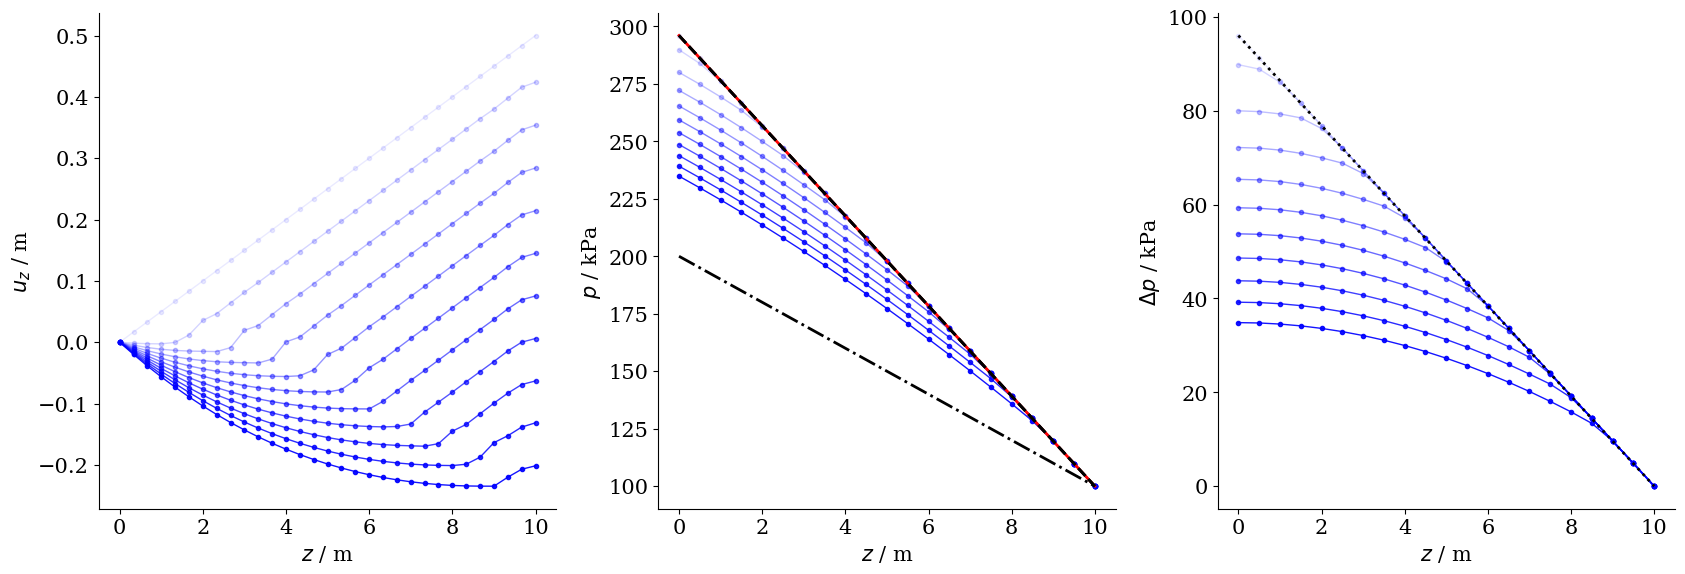

In [77]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
for i, t in enumerate(times):
    sol_u, sol_p = split_sol(len(elements_u), sols_dd[i],nodes_per_element_u,nodes_per_element_p)
    ax[0].plot(nodes_u, sol_u, color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1)
    ax[1].plot(nodes_p, sol_p/1e3, color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1)
    ax[2].plot(nodes_p, sol_p/1e3- (p_drawdown(t)/1e3 - gamma_w()/1e3*(10-nodes_p)), color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1, label=r'$t = %i$ d' % (t/day_in_sec))

ax[1].plot(nodes_p,p_0/1e3,color='red')
ax[1].plot(nodes_p, p_drawdown(t)/1e3-(gamma_r(0))/1e3*(10-nodes_p),color='black',ls='--',label=r'$\gamma_\mathrm{r} z$')
ax[1].plot(nodes_p, p_top(t)/1e3-(gamma_r(0))/1e3*(10-nodes_p),color='black',ls='--',label=r'$\gamma_\mathrm{r} z$')
ax[1].plot(nodes_p, p_top(t)/1e3-(gamma_w())/1e3*(10-nodes_p),color='black',ls='-.',label=r'$\gamma_\mathrm{w} z$')
ax[2].plot(nodes_p, -(gamma_r(0)-gamma_w())/1e3*(10-nodes_p),color='black',ls=':',label=r'$(\gamma_\mathrm{r}-\gamma_\mathrm{w}) z$')

ax[0].set_xlabel(r'$z$ / m')
ax[1].set_xlabel(r'$z$ / m')
ax[2].set_xlabel(r'$z$ / m')
ax[0].set_ylabel(r'$u_z$ / m')
ax[1].set_ylabel(r'$p$ / kPa')
ax[2].set_ylabel(r'$\Delta p$ / kPa')
#ax[2].set_ylim(0,50)
# Add the legend next to the plots
handles, labels = ax[2].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the layout to make room for the legend